In [51]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np 
import os
import math
import skimage as ski

Funcition turns all .jpg files into bitmap format:

In [52]:
def cutThirdDimension(bitmap):
    if bitmap.ndim == 3:
        return bitmap[..., 0]
    else:
        return bitmap

In [53]:
def scaleBitmap(bitmap):
    return bitmap/255.0

In [54]:
def turnJpgIntoBitmap(directory):  
    bitmap_files = []
    jpg_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.lower().endswith('.jpg')]
    for file in jpg_files:
        img = Image.open(file)
        bitmap = np.array(img)
        bitmap_files.append(scaleBitmap(cutThirdDimension(bitmap)))
    return bitmap_files

In [55]:
def turnSingleJpgIntoBitmap(single_file):
    directory = r"Tomograf-images"
    jpg_file = os.path.join(directory, single_file)
    if single_file.lower().endswith('.jpg'):
        img = Image.open(jpg_file)
        bitmap = np.array(img)
        return scaleBitmap(cutThirdDimension(bitmap))
    else:
        print('Wrong file format')
        exit()
    

In [56]:
def bresenhamAlgorithm(x1, y1, x2, y2):
    points = []
    x = x1
    y = y1
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    # Direction of the algorithm
    xi = 1 if x1 < x2 else -1
    yi = 1 if y1 < y2 else -1

    # First pixel
    points.append((x,y))

    if dx > dy:
        # Algorithm operates on the leading axis OX
        
        d = 2*dy - dx
        while x != x2:
            # Incrementing D according to algorithm
            if d >= 0:
                # Move diagonally
                x += xi
                y += yi
                d += 2*(dy-dx)
            else:
                # Move horizzontally
                d += 2*dy
                x += xi
            points.append((x,y))
    else:
        # Algorithm operates on the leading axis OY

        d = 2*dx - dy
        while y != y2:
            # Incrementing D according to algorithm
            if d >= 0:
                # Move diagonally
                x += xi
                y += yi
                d += 2*(dx-dy)
            else:
                # Move vertically
                d += 2*dx
                y += yi
            points.append((x,y))
    return points

In [57]:
def resizeImage(bitmap):
    # Get the dimensions of the input bitmap (rectangle)
    a = bitmap.shape[0]
    b = bitmap.shape[1]

    # Calculate the radius and diameter of the circle that will fit the input bitmap
    radius = int(np.sqrt((a/2)**2 + (b/2)**2))
    diameter = 2*radius

    # Calculate offsets to fill with black pixels
    offset_a = (diameter - a)//2
    offset_b = (diameter - b)//2

    # Create a bitmap with the desired dimensions
    big_bitmap = np.zeros((diameter, diameter))
    for i in range(offset_a, offset_a+a):
        for j in range(offset_b, offset_b+b):
            big_bitmap[i][j] = bitmap[i- offset_a][j - offset_b]

    return big_bitmap

In [58]:
def radonTransform(bitmap , step, detectors_span, detectors_number):
    bitmap = resizeImage(bitmap)

    size = max(bitmap.shape)
    center = size//2
    radius = size//2 - 1

    angles = np.deg2rad(np.arange(0,360,step))
    span_rad = np.deg2rad(detectors_span)

    sinogram = np.zeros((len(angles), detectors_number), dtype=bitmap.dtype)

    for a_i, angle in enumerate(angles):
        # Emitter coordinates
        x = int(center + radius*np.cos(angle))
        y = int(center + radius*np.sin(angle))

        # Calculate detectors placements for each emiiter 
        for d_i in range(detectors_number):
            # Detector coordinates
            x_d = int(center + radius*np.cos(angle + np.pi - span_rad/2 + (d_i*span_rad)/(detectors_number-1)))
            y_d = int(center + radius*np.sin(angle + np.pi - span_rad/2 + (d_i*span_rad)/(detectors_number-1)))

            # Ray between emitter and detector
            bresenham_points = bresenhamAlgorithm(x, y, x_d, y_d)
            
            # Calculate sinogram single point
            total_intensity = np.mean([bitmap[x_b, y_b] for x_b, y_b in bresenham_points if 0 <= x < size and 0 <= y < size])
            sinogram[a_i, d_i] = total_intensity

    return sinogram

In [59]:
def filtering(bitmap, kernel_size = 21):
    # Ensure that the kernel size is odd
    if kernel_size%2==0:
        kernel_size += 1
    kernel = np.zeros(kernel_size)	

    # Calculate middle index (kernel is indexed from -k to k są the middle index is k=0)
    middle_idx = kernel_size//2
    kernel[middle_idx] = 1

    # Calculate kernel values for negative k:
    # h[k] = 0, if k is even
    # h[k] = (-4/pi^2)/k^2, if k is odd
    for i in range(1, middle_idx, 2):
        kernel[i] = (-4/(np.pi**2)) / ((i-middle_idx)**2) 

    # Mirror first half of kernel into the second half
    kernel[-middle_idx:] = kernel[:middle_idx][::-1]

    # Use convolution
    for it, i in enumerate(bitmap):
        bitmap[it] = np.convolve(i, kernel, mode='same')
    return bitmap

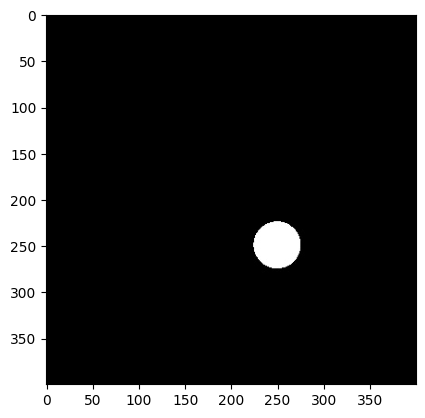

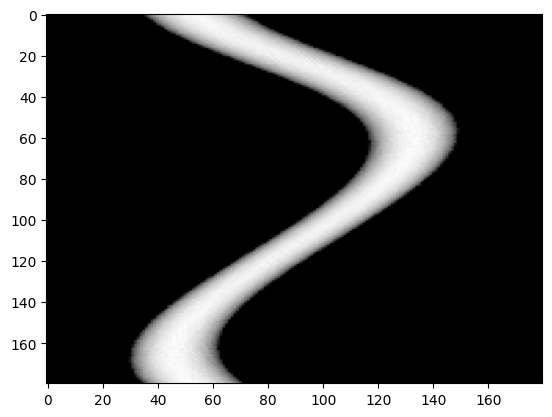

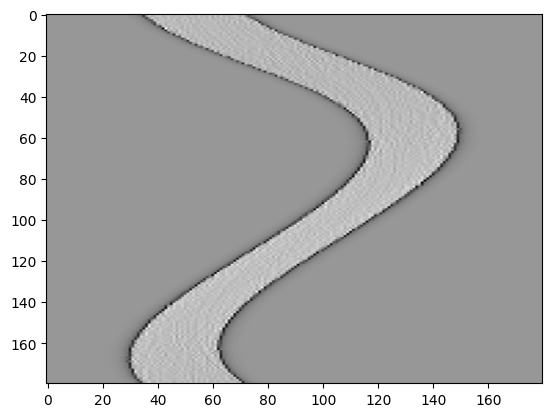

In [60]:
if __name__ == '__main__':
    #For multiple files turning into bitmaps
    # bitmap_files = turnJpgIntoBitmap(r"Tomograf-images")
    # for file in bitmap_files:
    #     plt.imshow(file, cmap='gray')
    #     plt.show()

    #Single file into bitmap
    bitmap = turnSingleJpgIntoBitmap('Kropka.jpg')
    plt.imshow(bitmap, cmap='gray')
    plt.show()

    sinogram = radonTransform(bitmap=bitmap, step=2, detectors_span=120, detectors_number=180)
    plt.imshow(sinogram, cmap='gray', aspect='auto')
    plt.show()

    sinogram = filtering(sinogram, 21)
    plt.imshow(sinogram, cmap='gray', aspect='auto')
    plt.show()